Using device: cuda
Epoch 1/25 | Train Acc: 0.264 | Test Acc: 0.419 | Weight Norm: 22.55
Epoch 2/25 | Train Acc: 0.409 | Test Acc: 0.537 | Weight Norm: 22.90
Epoch 3/25 | Train Acc: 0.481 | Test Acc: 0.562 | Weight Norm: 23.33
Epoch 4/25 | Train Acc: 0.533 | Test Acc: 0.654 | Weight Norm: 23.83
Epoch 5/25 | Train Acc: 0.583 | Test Acc: 0.672 | Weight Norm: 24.39
Epoch 6/25 | Train Acc: 0.623 | Test Acc: 0.692 | Weight Norm: 25.13
Epoch 7/25 | Train Acc: 0.665 | Test Acc: 0.681 | Weight Norm: 26.15
Epoch 8/25 | Train Acc: 0.711 | Test Acc: 0.684 | Weight Norm: 27.69
Epoch 9/25 | Train Acc: 0.782 | Test Acc: 0.653 | Weight Norm: 29.79
Epoch 10/25 | Train Acc: 0.867 | Test Acc: 0.626 | Weight Norm: 31.97
Epoch 11/25 | Train Acc: 0.933 | Test Acc: 0.609 | Weight Norm: 33.60
Epoch 12/25 | Train Acc: 0.956 | Test Acc: 0.616 | Weight Norm: 34.90
Epoch 13/25 | Train Acc: 0.973 | Test Acc: 0.628 | Weight Norm: 35.82
Epoch 14/25 | Train Acc: 0.987 | Test Acc: 0.633 | Weight Norm: 36.35
Epoch 15/2

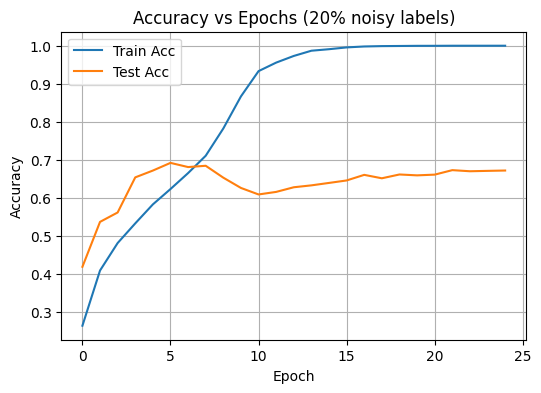

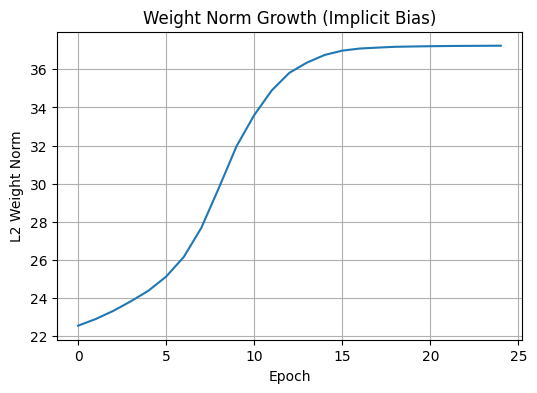

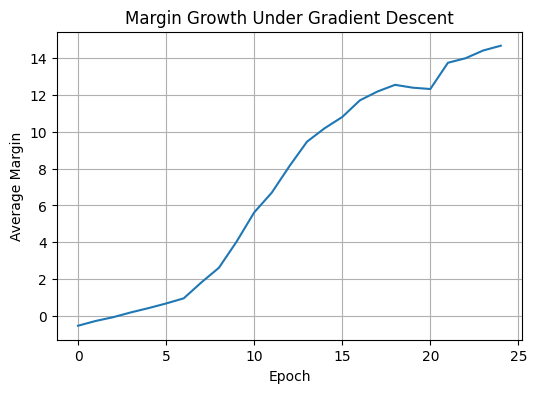

Saved plots:
 - implicit_bias_accuracy.png
 - implicit_bias_weight_norm.png
 - implicit_bias_margin.png


In [3]:
# ================================================================
# IMPLICIT BIAS OF GRADIENT DESCENT — WIDE CNN ON CIFAR-10 (ONE CELL)
# ================================================================

import torch, torch.nn as nn, torch.optim as optim
import torchvision, torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------------------------------------
# 1. Dataset + 20% Label Noise
# ------------------------------------------------------------
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# Apply 20% noise on training labels
noise_ratio = 0.2
num_noisy = int(len(trainset) * noise_ratio)
noise_idx = np.random.choice(len(trainset), num_noisy, replace=False)

clean_targets = np.array(trainset.targets)
noisy_targets = clean_targets.copy()

for i in noise_idx:
    noisy_targets[i] = np.random.randint(0,10)

trainset.targets = noisy_targets.tolist()

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False)

# ------------------------------------------------------------
# 2. Wide CNN (ResNet-style)
# ------------------------------------------------------------
class WideConvNet(nn.Module):
    def __init__(self, k=4):  # widen factor
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16*k, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16*k, 32*k, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32*k, 64*k, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64*k, 128*k, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*k*8*8, 512), nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

model = WideConvNet(k=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.02, momentum=0.9)

# ------------------------------------------------------------
# Utility functions: margin and weight norm
# ------------------------------------------------------------
def compute_weight_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        total_norm += p.norm(2).item() ** 2
    return np.sqrt(total_norm)

def compute_margin(model, loader):
    model.eval()
    margins = []
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            correct_logits = logits[torch.arange(len(y)), y]
            max_others = logits.clone()
            max_others[torch.arange(len(y)), y] = -1e9
            margins.append((correct_logits - max_others.max(dim=1).values).mean().item())
    return np.mean(margins)

# ------------------------------------------------------------
# 3. Training Loop
# ------------------------------------------------------------
epochs = 25
train_acc_hist = []
test_acc_hist = []
weight_norm_hist = []
margin_hist = []

for ep in range(epochs):
    model.train()
    correct = 0
    total = 0

    for X, y in trainloader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += len(y)

    train_acc = correct / total

    # Evaluate test accuracy
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X, y in testloader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            pred = logits.argmax(1)
            correct += (pred == y).sum().item()
            total += len(y)
    test_acc = correct / total

    # Track metrics
    train_acc_hist.append(train_acc)
    test_acc_hist.append(test_acc)
    weight_norm_hist.append(compute_weight_norm(model))
    margin_hist.append(compute_margin(model, trainloader))

    print(f"Epoch {ep+1}/{epochs} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f} | Weight Norm: {weight_norm_hist[-1]:.2f}")

# ------------------------------------------------------------
# 4. PLOTS
# ------------------------------------------------------------

# Accuracy plot
plt.figure(figsize=(6,4))
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(test_acc_hist, label="Test Acc")
plt.title("Accuracy vs Epochs (20% noisy labels)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.savefig("implicit_bias_accuracy.png", dpi=150)
plt.show()

# Weight Norm plot
plt.figure(figsize=(6,4))
plt.plot(weight_norm_hist)
plt.title("Weight Norm Growth (Implicit Bias)")
plt.xlabel("Epoch")
plt.ylabel("L2 Weight Norm")
plt.grid()
plt.savefig("implicit_bias_weight_norm.png", dpi=150)
plt.show()

# Margin plot
plt.figure(figsize=(6,4))
plt.plot(margin_hist)
plt.title("Margin Growth Under Gradient Descent")
plt.xlabel("Epoch")
plt.ylabel("Average Margin")
plt.grid()
plt.savefig("implicit_bias_margin.png", dpi=150)
plt.show()

print("Saved plots:")
print(" - implicit_bias_accuracy.png")
print(" - implicit_bias_weight_norm.png")
print(" - implicit_bias_margin.png")
